In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    pi = 3.141592
    c = 3e8
    e = 1.6e-19

    mu_B = 5.788 * 10**-9   # eV / Gauss
    hbar = 6.58 * 10**-16   # eV * s
class setup:
    dummy = 0
    probe_d = 14.3          # mm
    probe_d_err = 0.1       # mm
    probe_N = 49            # turns
    freq = 50               # Hz
    freq_err = 1            # Hz
    

### Magnets calibration

In [3]:
calibration_data = mipt.read_excel('data/5101.xlsx', usecols=('J', 'K'), header=(0, 1))

fmt = {
    'V_r, mV' : 'V',
    'V_probe, mV' : 'V_probe',
    'Main coils' : 'Calibration'
}

calibration_data = mipt.map_excel(calibration_data, fmt)
calibration_data

Calibration        
             V V_probe
0        11.12    1.36
1        17.58    2.16
2        28.20    3.48
3        35.83    4.46
4        43.02    5.33
5        51.90    6.42
6        59.80    7.39
7        65.80    8.18
8        73.51    9.16
9          NaN     NaN
10         NaN     NaN
11         NaN     NaN
12         NaN     NaN
13         NaN     NaN
14         NaN     NaN
15         NaN     NaN
16         NaN     NaN
17         NaN     NaN
18         NaN     NaN
19         NaN     NaN

In [4]:
V = 0.001 * calibration_data['Calibration', 'V_probe'] 
S = 1/4 * np.pi * (setup.probe_d / 1000) ** 2
omega = 2 * np.pi * setup.freq
calibration_data['Calibration', 'B'] = 10000 * V / ( setup.probe_N * S * omega) # Gauss

calibration_data

Calibration                   
             V V_probe          B
0        11.12    1.36   5.500865
1        17.58    2.16   8.736668
2        28.20    3.48  14.075743
3        35.83    4.46  18.039602
4        43.02    5.33  21.558538
5        51.90    6.42  25.967319
6        59.80    7.39  29.890731
7        65.80    8.18  33.086086
8        73.51    9.16  37.049945
9          NaN     NaN        NaN
10         NaN     NaN        NaN
11         NaN     NaN        NaN
12         NaN     NaN        NaN
13         NaN     NaN        NaN
14         NaN     NaN        NaN
15         NaN     NaN        NaN
16         NaN     NaN        NaN
17         NaN     NaN        NaN
18         NaN     NaN        NaN
19         NaN     NaN        NaN

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,42.973333,416.122644,21.545055,105.817059,209.834816,0.504262,0.001355,-0.124762,0.064439


4.917857859812961


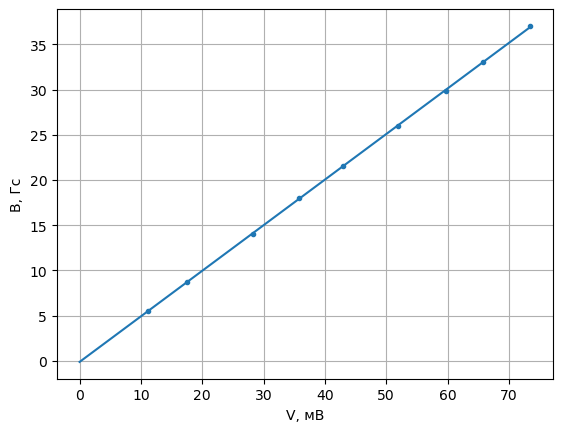

In [5]:
d = calibration_data['Calibration']
x, y, V2B = mipt.plot(d['V'], d['B'], x_min=0)
plt.xlabel('V, мВ')
plt.ylabel('B, Гс')
plt.grid()
plt.savefig('gen/calibration.pdf')

V2B_eps = (2*(setup.probe_d_err/setup.probe_d)**2 + (setup.freq_err/setup.freq)**2)**0.5
mnk = mipt.mnk(x, y).data
display(mnk)
print(V2B(10)) # Sanity check
dV2dB = lambda v: V2B(v) - V2B(0) # for errors and deltas

In [6]:
d = calibration_data['Calibration'].dropna()
display(d)
fmt = {
    'V' : [r'$V$, мВ', '{:.2f}'],
    'V_probe' : [r'$V_{probe}$, мВ', '{:.2f}'],
    'B' : [r'$B$, Гс', '{:.1f}']
}

table = mipt.table(d, fmt)
table.to_latex('gen/calibration.tex')

,V,V_probe,B
0,11.12,1.36,5.500865
1,17.58,2.16,8.736668
2,28.20,3.48,14.075743
3,35.83,4.46,18.039602
4,43.02,5.33,21.558538
5,51.90,6.42,25.967319
6,59.80,7.39,29.890731
7,65.80,8.18,33.086086
8,73.51,9.16,37.049945


### EPR frequency

In [7]:
data = mipt.read_excel('data/5101.xlsx', usecols=('A', 'B', 'C', 'D'), header=(0)).dropna()
fmt = {
    'f, MHz' : 'f',
    'V, mV' : 'V',
    'V_left, mV' : 'V_left',
    'V_right, mV' : 'V_right',
    'Width, 10*cell' : 'width'
}
data = mipt.map_excel(data, fmt)
data

,f,V,V_left,V_right
0,108.895,79.12,88.68,70.14
1,98.663,71.73,81.01,62.47
2,118.613,86.57,95.82,77.32
3,128.767,94.16,103.58,84.74
4,138.597,100.75,109.68,91.14
5,148.547,108.43,117.80,99.21
6,88.697,64.97,74.74,56.22
7,78.504,57.24,67.11,48.15
8,68.514,49.88,59.75,40.32


In [8]:
data['B'] = V2B(data['V'])
data['B_left'] = V2B(data['V_left'])
data['B_right'] = V2B(data['V_right'])
data

,f,V,V_left,V_right,B,B_left,B_right
0,108.895,79.12,88.68,70.14,39.772444,44.593188,35.244171
1,98.663,71.73,81.01,62.47,36.045948,40.725499,31.376482
2,118.613,86.57,95.82,77.32,43.529195,48.193618,38.864772
3,128.767,94.16,103.58,84.74,47.356544,52.106691,42.606396
4,138.597,100.75,109.68,91.14,50.679630,55.182689,45.833672
5,148.547,108.43,117.80,99.21,54.552362,59.277296,49.903066
6,88.697,64.97,74.74,56.22,32.637137,37.563776,28.224845
7,78.504,57.24,67.11,48.15,28.739192,33.716258,24.155451
8,68.514,49.88,59.75,40.32,25.027824,30.004890,20.207080


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,39.815586,90.329276,6.826311e+08,2.636347e+16,1.543079e+09,1.708282e+07,72542.273964,2.468520e+06,2.969461e+06


g = 1.942 +- 0.044
g = 2 (reference)


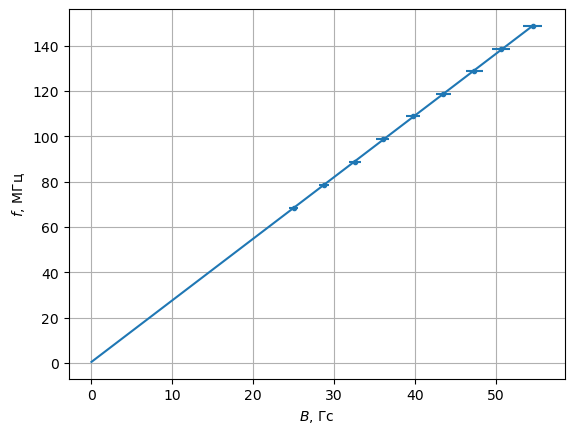

In [9]:
x, y, _ = mipt.plot(data['B'], data['f'], x_min=0, xerr=data['B'] * V2B_eps)
plt.grid()
plt.xlabel('$B$, Гс')
plt.ylabel('$f$, МГц')
plt.savefig('gen/epr.pdf')

mnk = mipt.mnk(x, 2 * np.pi * y * 1e6).data
display(mnk)

a = mnk['a'][0]
a_err = mnk['da'][0]
g = a * consts.hbar / consts.mu_B
g_err = g * ((a_err/a)**2 + V2B_eps**2)**0.5
print(f"g = {g:.3f} +- {g_err:.3f}")
print(f"g = 2 (reference)")

In [10]:
data.sort_values(by='f', ignore_index=True, inplace=True)
display(data)
fmt = {
    'f' : [r'$f$, МГц', '{:.3f}'],
    'V' : [r'$V$, мВ', '{:.2f}'],
    'V_left' : [r'$V_{left}$, мВ', '{:.2f}'],
    'V_right' : [r'$V_{right}$, мВ', '{:.2f}'],
    'B' : [r'$B$, Гс', '{:.1f}'],
    'B_left' : [r'$B_{left}$, Гс', '{:.1f}'],
    'B_right' : [r'$B_{right}$, Гс', '{:.1f}'],
}

table = mipt.table(data, fmt)
table.to_latex('gen/epr.tex')

,f,V,V_left,V_right,B,B_left,B_right
0,68.514,49.88,59.75,40.32,25.027824,30.004890,20.207080
1,78.504,57.24,67.11,48.15,28.739192,33.716258,24.155451
2,88.697,64.97,74.74,56.22,32.637137,37.563776,28.224845
3,98.663,71.73,81.01,62.47,36.045948,40.725499,31.376482
4,108.895,79.12,88.68,70.14,39.772444,44.593188,35.244171
5,118.613,86.57,95.82,77.32,43.529195,48.193618,38.864772
6,128.767,94.16,103.58,84.74,47.356544,52.106691,42.606396
7,138.597,100.75,109.68,91.14,50.679630,55.182689,45.833672
8,148.547,108.43,117.80,99.21,54.552362,59.277296,49.903066


### Peaks width

[2.4885327204733017,
 2.410372118310514,
 2.488532720473298,
 2.291870560192738,
 2.4633196230014356,
 2.2061460287883854,
 2.339775445389286,
 2.3347328258949105,
 2.4103721183105122,
 2.264136152973684,
 2.3322115161477264,
 2.332211516147723,
 2.375073781849899,
 2.375073781849899,
 2.251529604237753,
 2.4229786670464435,
 2.3624672331139642,
 2.324647586906167]

Width = (2.36 +- 0.15) Gauss


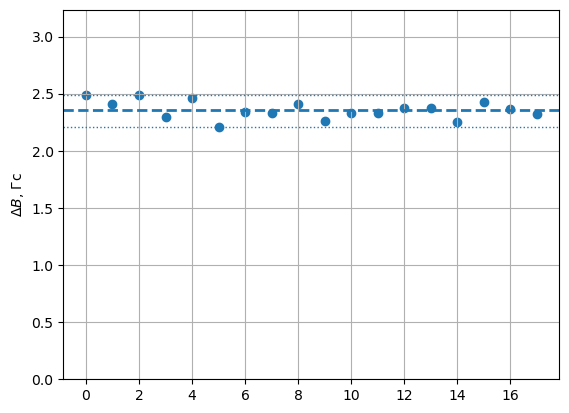

In [11]:
import math
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

width_data = []
for center, left, right in zip(data['B'], data['B_left'], data['B_right']):
    width_data.append((left - center) / 2)    # V_left corresponds to peak shifted left for 2 cells
    width_data.append((center - right) / 2)

display(width_data)

width = np.mean(width_data)
width_min = np.min(width_data)
width_max = np.max(width_data)

plt.scatter(range(0, len(width_data)), width_data)
plt.axhline(y=width, linestyle='--', linewidth=2)
plt.axhline(y=width_min, linestyle=':', linewidth=1)
plt.axhline(y=width_max, linestyle=':', linewidth=1)

ax = plt.gca()
ax.set_ylim([0, max(width_data) * 1.3])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.ylabel('$\Delta B$, Гс')
plt.grid()
plt.savefig('gen/widths.pdf')

width_err = np.max([width_max - width, width - width_min])
print(f'Width = ({width:.2f} +- {width_err:.2f}) Gauss')


In [12]:
data = mipt.read_excel('data/5101.xlsx', usecols=('A', 'B', 'E'), header=(0)).dropna()
data.reset_index(drop=True, inplace=True)
fmt = {
    'f, MHz' : 'f',
    'V, mV' : 'V',
    'Width, 10*cell' : 'width',
}
data = mipt.map_excel(data, fmt)
data['width'] *= 10  # convert to amount of cells
data['B'] = V2B(data['V'])
data['B_width'] = data['width'] * width
data

,f,V,width,B,B_width
0,108.895,79.12,1.685393,39.772444,3.976965
1,98.663,71.73,1.670588,36.045948,3.94203
2,118.613,86.57,1.697368,43.529195,4.005222
3,128.767,94.16,1.625,47.356544,3.834457
4,88.697,64.97,1.607595,32.637137,3.793387
5,78.504,57.24,1.612903,28.739192,3.805913


In [13]:
mu = g * 1/2 * consts.mu_B
E_width = 2 * mu * data['B_width']
data['tau'] = consts.hbar / E_width
tau = np.mean(data['tau'])
tau_err = tau * ((g_err/g)**2 + (width_err/width)**2)**0.5
print(f'tau: ({tau*1e9:.1f} +- {tau_err*1e9:.1f}) нс')

tau: (15.0 +- 1.0) нс
